In [1]:
import numpy as np
np.random.seed(0)
from utils import *
from training import *
from transfer_learning import *
from figure_scripts import *
from models import sorbnet, dense
from keras.models import load_model

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load pretrained models on the MFI-C5-W system

Please change the first line into the path where you download the data from the MCCCS-DB repository.

In [2]:
data_dir = '../data_github/'
model = load_model('models/sorbnet-transfer.h5')
model_dense = load_model('models/dense-transfer.h5')

Run this cell to test the transferability of higher layer weights among similar sorption systems. The results printed can be validated against Table 2. 

Note that fitting to random weights ('random/fixed' row) is subjected to high instability so standard deviation in Table 2 underestimates the possible deviation from mean value reported.

In [3]:
test_temps = [343, 393, 443, 493]
target_tasks = ['MFI-C4-W', 'MFI-C5-E', 'LTA-C5-W']
for target in target_tasks:
    print(target)
    data_train = make_data(data_dir, target, test_temps=test_temps)
    data_eval = make_data(data_dir, target, test_temps=test_temps, train=False)
    
    fixed = copy_layers(model, [3, 4, 5, 6, 7, 8], trainable=False)
    train_model(fixed, data_train[:2])
    train_res, test_res = eval_model(fixed, data_eval)
    print('pretrained / fixed:\ttrain MSE %.6f' % calc_mse(train_res), '\t test MSE %.6f' % calc_mse(test_res))
    del fixed
    
    tune = copy_layers(model, [3, 4, 5, 6, 7, 8], trainable=True)
    train_model(tune, data_train[:2])
    train_res, test_res = eval_model(tune, data_eval)
    print('pretrined / trainable:\ttrain MSE %.6f' % calc_mse(train_res), '\ttest MSE %.6f' % calc_mse(test_res))
    del tune
                          
    random = copy_layers(sorbnet(4), [3, 4, 5, 6, 7, 8], trainable=False)
    train_model(random, data_train[:2])
    train_res, test_res = eval_model(random, data_eval)
    print('random / fixed:\t\ttrain MSE %.6f' % calc_mse(train_res), '\ttest MSE %.6f' % calc_mse(test_res))
    del random                      



MFI-C4-W
pretrained / fixed: train MSE 0.00030596130934327825 test MSE 0.0005280146977142308
pretrined / trainable: train MSE 0.0002408507258082255 test MSE 0.0003875370673160364
random / fixed: train MSE 0.024581432027545945 test MSE 0.024499343398322194
MFI-C5-E
pretrained / fixed: train MSE 0.00017451794919230883 test MSE 0.0004813967202839532
pretrined / trainable: train MSE 0.00011977737990479682 test MSE 0.0003704611917938885
random / fixed: train MSE 0.002868013385218307 test MSE 0.004165438503881798
LTA-C5-W
pretrained / fixed: train MSE 0.0003874570306267224 test MSE 0.0010427325841821774
pretrined / trainable: train MSE 0.00020220144046885675 test MSE 0.0005896088158495263
random / fixed: train MSE 0.06792911040159469 test MSE 0.0670616315646014


Run this cell to calculate the transfer learning results for target systems as the mean square error by each temperature.

In [17]:
transfer_temps = list(range(343, 423, 10)) + list(range(433, 503, 10))
target_tasks = ['MFI-C4-W', 'MFI-C5-E', 'LTA-C5-W', 'MFI-C5-W']
data = {}
for target in target_tasks:  
    data_transfer = make_data(data_dir, target, test_temps=transfer_temps)
    data_eval = make_data(data_dir, target, test_temps=transfer_temps, train=False)
    if target == 'MFI-C5-W':
        swap_sorbates(data_transfer)
        swap_sorbates(data_eval)
    
    sorbnet_transfer = make_trainable(model, [1, 2])
    train_model(sorbnet_transfer, data_transfer[:2], epochs=200)
    sorbnet_res = evaluate_by_temp(sorbnet_transfer, data_eval)
    del sorbnet_transfer
    
    dense_transfer = make_trainable(model_dense, [1, 2])
    train_model(dense_transfer, data_transfer[:2], epochs=200)
    dense_res = evaluate_by_temp(dense_transfer, data_eval)
    del dense_transfer
    
    baseline = sorbnet(4)
    train_model(baseline, data_transfer[:2], epochs=200) 
    baseline_res = evaluate_by_temp(baseline, data_eval)
    del baseline
                                    
    data[target] = np.vstack([sorbnet_res, dense_res, baseline_res]).T

Run this cell to plot the mean sequare errors in the format of Figure 4. Please be advised that the exact values can be different due to randomness of neural network training. However the main information should agree with Figure 4:
* Transfer learning produces significant lower errors than the baseline
* Sorbnet and dense network are on par in the first three systems while dense network transfers poorly in MFI-W-C5.
* Overall transfer performance (w/o the MFI-W-C5 artifact): MFI-C4-W > MFI-C5-E > LTA-C5-W

Also note that the y axis is shown in log scale so deviation from Figure 4 may appear to be more significant than estimated from error bars.

D:\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


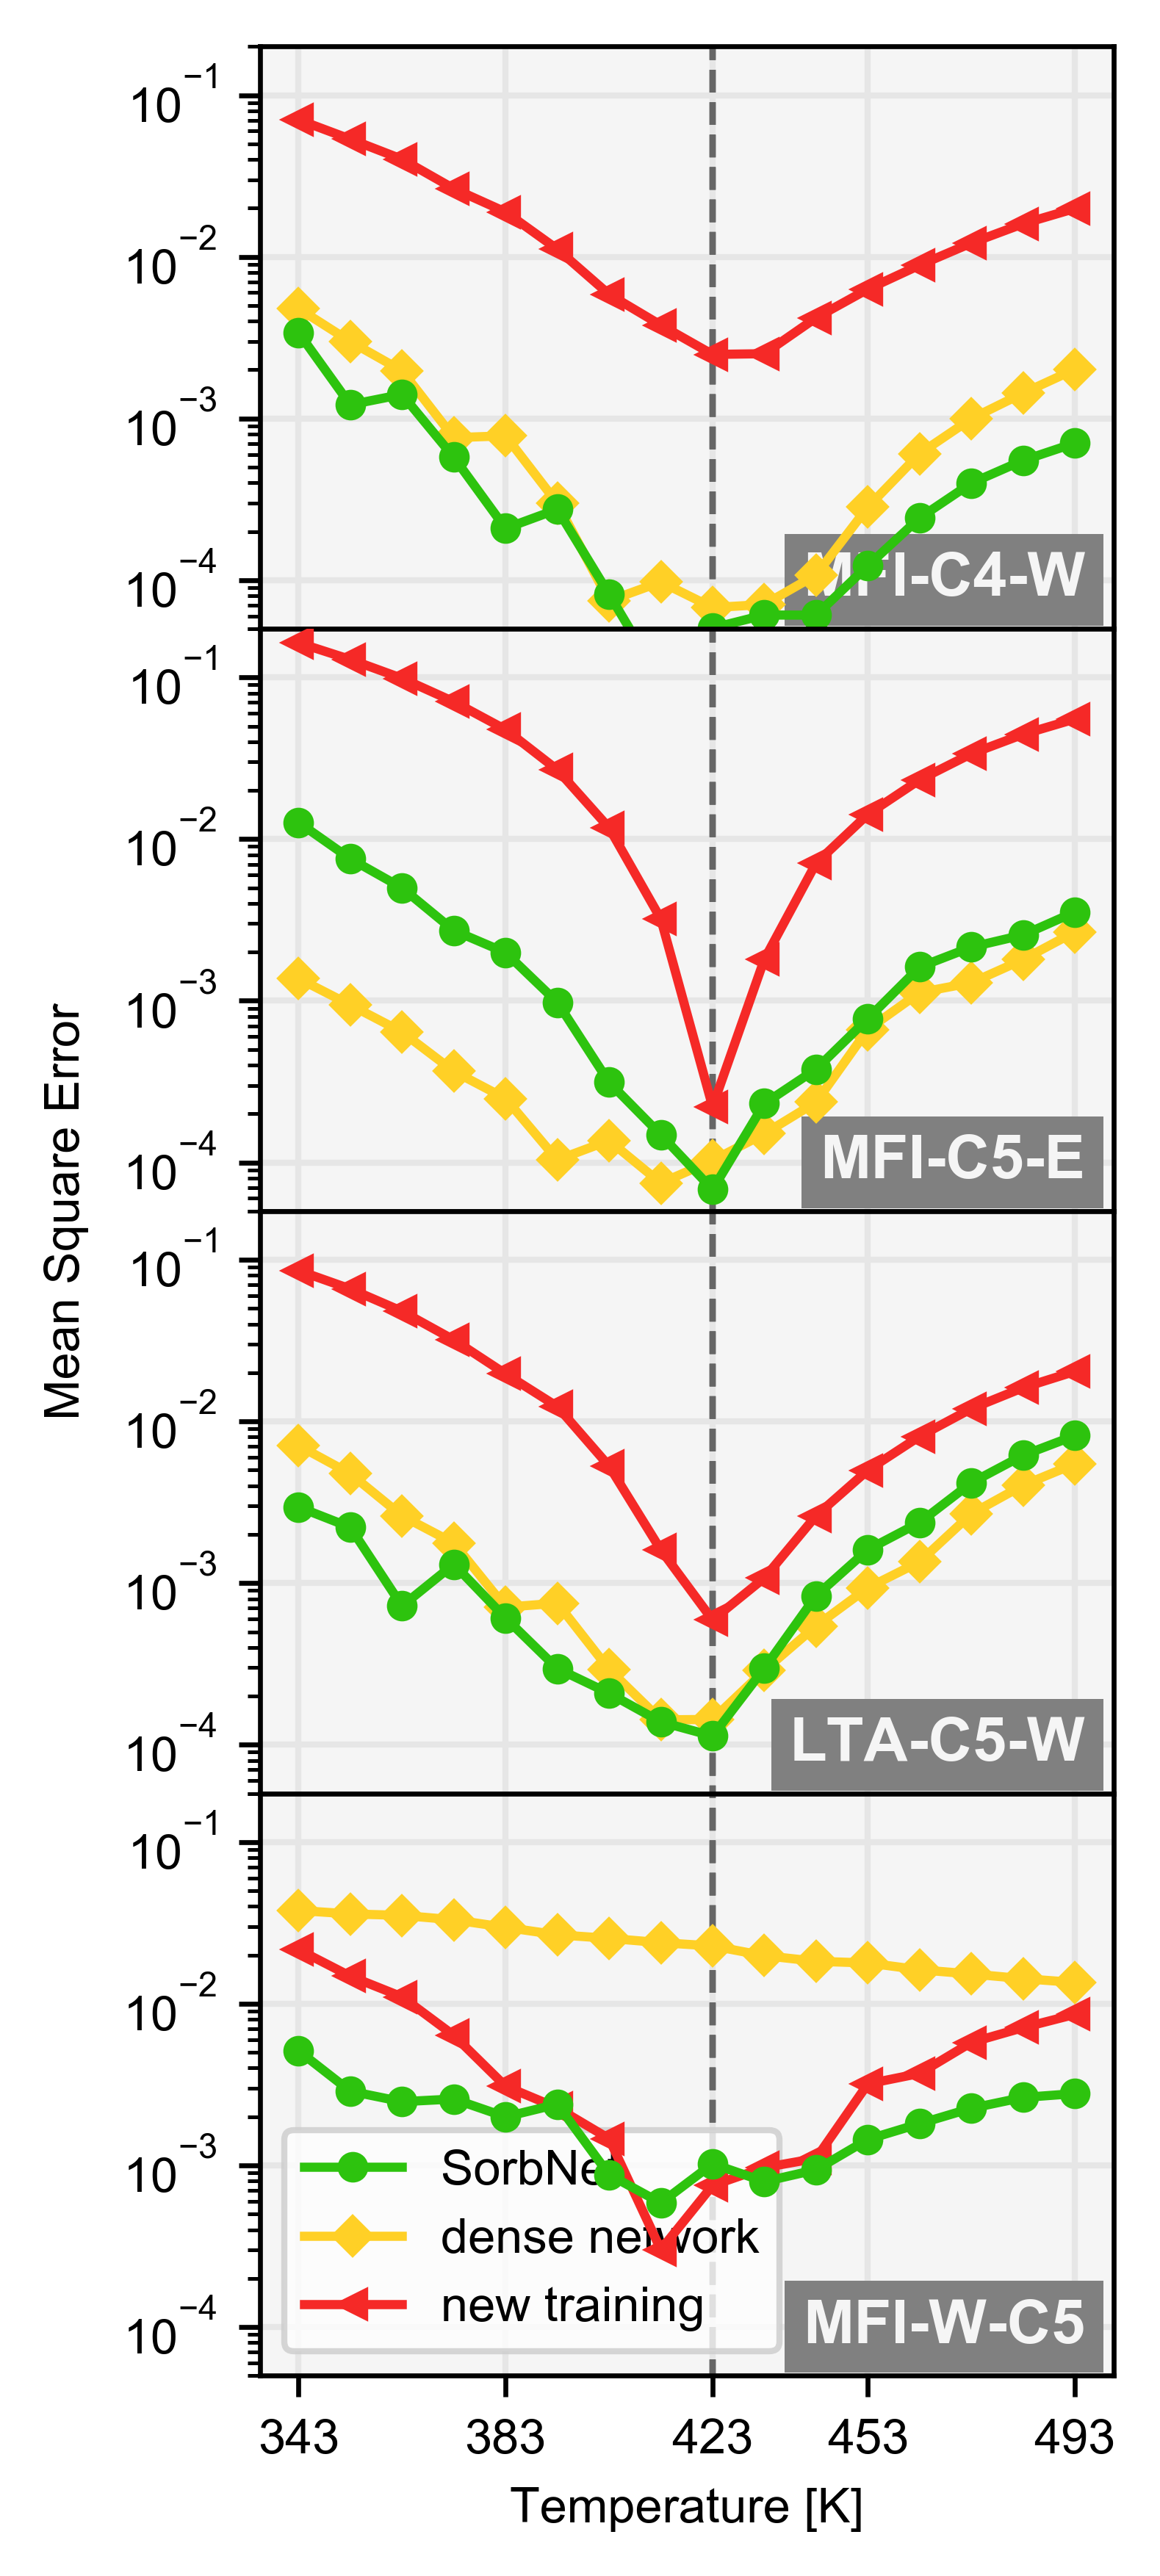

In [18]:
plot_by_temperature(data)